original data: [MIMIC-III](https://physionet.org/content/mimiciii/1.4/)  
cleaned data from : [kaggle](https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction) <br> more details in [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.0p2ngf1zd) 

Goal: 중환자실에 입원해있는 심부전 환자들의 생존율을 높인다.

Questions: 
- 생존과 관련된 징후에는 어떤 것이 있는가?
- 어떻게 연관되어있는가?
- 생존율을 높이기 위해선 어떤 조치를 취해야하는가?

조사 대상
- 18세 이상 환자
- 중환자실 기록, LVEF, NT-proBNP 기록이 존재하는 환자로  

사용한 데이터에서는 총 ICD-9에 있는 13389개의 환자 기록 중 위 조건을 만족하는 환자 1177개만 추출했다.

# Metadata

|  | 인구통계학적 특성 |  |
|-----|-------------------------|---|
| Age | 병원에 입원했을 때 나이 |  |
| Sex | 성별                    |  |
| BMI | 체질량 지수             | kg/m^2

<br>

|   중복이환           |        0: False 1: True          |
|---------------------|----------------------------------|
| Hypertension        | 고혈압                           | 
| Atrial Fibrillation | 심방 세동                        |
| CHD with no MI      | 선천적 심장병 없이 심근경색 발생 |
| Diabetes Mellitus   | 당뇨                             |
| Depression          | 우울증                           |
| Deficiency Anemias  | 철결핍빈혈                       |
| Hyperlipidemia      | 고지혈증                         |
| Renal failure       | 신부전                           |
| COPD                | 만성폐쇄성폐질환                 |

<br>

| 활력 징후(Vital Signs)        | 입원 시 최초 24시간동안 측정 | 단위 |
|-------------------------------|------------------------------|------|
| Heart Rate(HR)                | 심박수                       | bpm  |
| SBP (Systolic Blood Pressure)  | 수축기 혈압                  | mmHg |
| DBP (Diastolic Blood Pressure) | 이완기 혈압                  | mmHg |
| Respiratory Rate              | 분당 호흡 수                 | bpm  |
| Temperature                   | 체온                         | C    |
| SPO2 (Saturation Pulse Oxygen) | 혈중 산소 포화도             | %    |
| urine output                  | 소변 배출량                  | mL   |

<br>

| 임상병리 변수(Laboratory Variables)               | 혈액 내                          | 단위          |
|-------------------------------------------------|----------------------------------|---------------|
| Hematocrit                                      | 적혈구 용적률                    | %             |
| RBC (Red Blood Cells)                            | 적혈구 수                        | million/uL    |
| MCH (Mean Corpuscular Hemoglobin)                | 평균 적혈구 혈색소량             | pg            |
| MCHC (Mean Corpuscular Hemoglobin Concentration) | 평균 적혈구 혈색소 농도          | %             |
| MCV (Mean Corpuscular Volume)                    | 평균 적혈구 용적                 | fL            |
| RDW (Red Blood Cell Distribution Width)          | 적혈구 크기 분포                 | %             |
| Leucocyte                                       | 백혈구                           | thousand / mL |
| Platelets                                       | 혈소판                           | thousand / mL |
| Neutrophils                                     | 호중구                           | %             |
| Basophils                                       | 호염기구                         | %             |
| Lymphocyte                                      | 림프구                           | %             |
| PT (Prothrombin Time)                            | 프로트롬빈 시간                  | s             |
| INR (International Normalized Ratio)             | PT를 국제적으로 표준화한 단위    |               |
| NT-proBNP                                       | N 말단 뇌성 나트륨 이뇨 펩타이드 | pg/mL         |
| Creatine Kinase                                 | 크레아틴 키나제                  | U/L           |
| Creatinine                                      | 크레아티닌                       | mg/dL         |
| BUN (Blood Urea Nitrogen)                        | 혈액 요소 질소                   | mg/dL         |
| Glucose                                         | 포도당                           | mg/dL         |
| Potassium                                       | 포타슘                           | mEq/L         |
| Sodium                                          | 소듐                             | mEq/L         |
| Calcium                                         | 칼슘                             | mmol/L        |
| Chloride                                        | 염화이온                         | mEq/L         |
| Anion gap                                       | 음이온차                         | mEq/L         |
| Magnesium ion                                   | 마그네슘 이온                    | mg/dL         |
| pH                                              | 수소 이온 농도 지수              |               |
| Bicarbonate                                     | 탄산수소염                       | mEq/L         |
| Lactate acid                                    | 락트산                           | mmol/L        |
| PCO2                                            | 동맥혈 탄산 가스 분압            | mmHg          |
| LVEF (Left Ventricular Ejection Fraction)        | 좌심실 박출률                    | %             |

- `outcome`: 생존 여부 / 0: 생존, 1: 사망

특성별로 EDA할때 normal range 추가하기, 어떤 영향을 주는건지 설명 추가, LVEF는 직접적인 영향을 줄거같은데 drop 해야하나? 다 돌려보기

# Import and Load

In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report

import umap
import umap.plot
import lightgbm as lgbm
from lightgbm import LGBMClassifier

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./data/In_hospital_mortality_prediction.csv')

In [3]:
df.sample(5)

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
630,1,167408,1.0,74,1,NaN,1,1,0,1,1,0,0,1,0,83.739130,98.000000,61.043478,19.391304,36.666667,96.590909,810.0,28.909091,4.342000,20.870000,31.140000,67.100000,23.060000,15.440000,216.800000,82.75,NaN,12.25,37.190000,4.030000,13113.0,78.000000,1.166667,23.416667,70.222222,3.566667,132.562500,7.210000,98.250000,14.833333,1.850000,7.364444,23.250000,3.658333,41.875,25
782,1,113198,0.0,80,2,31.875000,0,0,0,0,1,0,0,1,0,68.086957,102.000000,42.956522,22.136364,36.611111,92.217391,1585.0,31.233333,3.054286,33.171429,32.228571,103.000000,18.342857,10.500000,192.000000,82.90,0.30,10.70,13.975000,1.200000,13980.0,180.428571,2.200000,65.375000,116.166667,4.200000,139.375000,8.457143,100.375000,14.500000,2.262500,NaN,28.750000,NaN,NaN,50
829,2,140961,0.0,65,2,41.363963,1,0,0,1,0,0,1,1,0,104.185185,127.125000,60.416667,16.740741,37.000000,96.925926,5900.0,29.933333,3.416667,29.133333,33.266667,88.000000,14.966667,8.166667,312.000000,74.40,0.45,17.35,12.400000,1.050000,1443.0,378.200000,1.587500,32.125000,109.666667,4.300000,140.111111,9.500000,101.666667,14.000000,2.057143,7.320000,29.125000,0.733333,46.000,55
1026,2,151316,0.0,79,2,NaN,1,0,0,1,1,0,1,0,0,81.366667,120.185185,46.407407,21.315789,38.798889,99.354839,1215.0,30.909091,3.461818,29.418182,32.990909,89.090909,15.136364,8.363636,193.363636,67.15,1.15,26.50,13.325000,1.137500,1140.0,127.333333,0.823077,17.076923,240.500000,3.950000,140.928571,7.625000,109.785714,12.846154,1.953846,7.326471,22.692308,2.125000,41.500,55
476,1,102064,0.0,71,1,25.252397,0,1,0,0,0,0,0,0,1,108.740741,107.678571,62.678571,23.178571,36.444444,97.275862,1360.0,33.428571,3.507143,30.771429,32.285714,95.285714,16.471429,15.600000,189.857143,90.30,0.20,4.22,30.183333,3.016667,380.0,102.400000,0.900000,25.571429,138.000000,4.157143,143.285714,8.533333,105.571429,13.714286,2.100000,7.381250,28.142857,2.062500,49.500,55


In [4]:
df[df['outcome'].isna()]

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
1159,2,162338,NaN,83,1,NaN,1,0,0,1,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.9125,3.9375,29.7,32.5625,91.375,15.1,8.25,226.0,78.0,0.3,12.55,11.3,0.933333,14649.5,82.4,4.2125,42.0,NaN,4.4375,130.666667,7.45,92.625,15.5,1.983333,NaN,26.5,NaN,NaN,55


In [5]:
df.columns = (list(df.columns[:6]) + 
              ['Hypertensive', 'Atrial Fibrillation', 'CHD with no MI', 'Diabetes', 'Deficiency Anemias', 'Depression'] +
              list(df.columns[12:]))

1177개의 데이터 중 30%(group 2, n=352)는 모델 성능을 확인하기 위한 테스트 데이터로 분리한다.  
데이터 중 타겟이 결측치인 경우가 있다. 이 데이터는 모델이 맞췄는지 알 수 없기 때문에 삭제해준다.

In [6]:
df = df[df['outcome'].notna()]

train = df.query("group==1")
test = df.query("group==2")

# Preprocessing

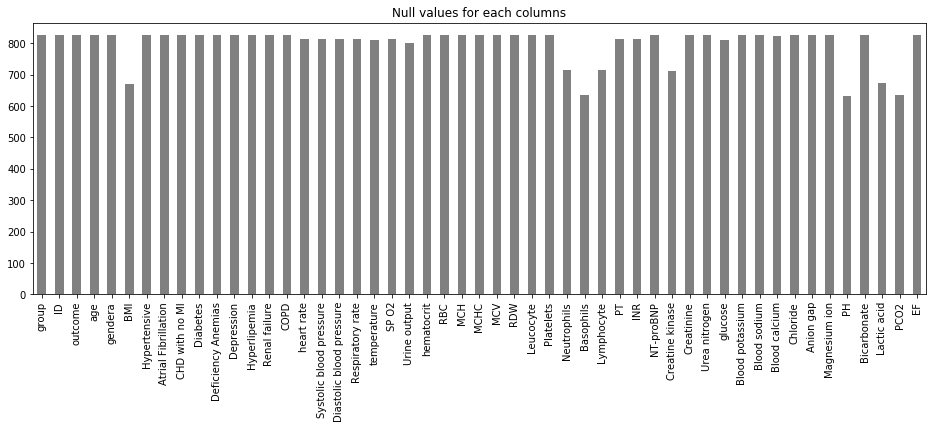

In [7]:
train.notna().sum().plot(kind='bar', figsize=(16, 5), color='gray')
plt.title("Null values for each columns")
plt.show()

In [8]:
col_w_nulls = train.columns[train.isna().any()].values

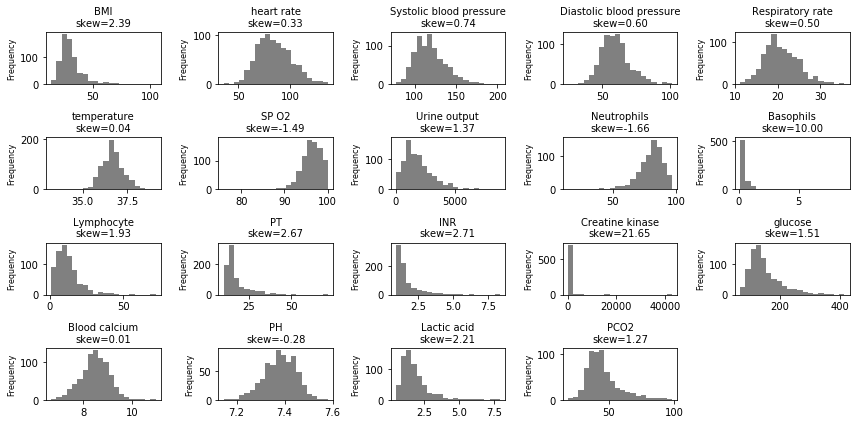

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(12, 6))
for col, ax in zip(col_w_nulls, axes.ravel()):
    train[col].plot(kind='hist', bins=20, color='gray', ax=ax)
    ax.set_title(f"{col}\nskew={train[col].skew():.2f}", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=8)
    
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

전체 특성 중 결측치를 가지는 특성의 분포를 확인했다.

전체 데이터중 훈련 데이터로 사용할 그룹(1)을 기준으로 결측치 처리를 해주었다. Skewness로 정규분포를 따르는지 확인해 정규분포 형태를 띄는 연속형 변수는 특성의 변수로 바꾸어주고, 불균형한 연속형 데이터의 경우에는 중앙값으로 결측치를 보완해준다.  

크레아틴키나제(Creatine kinase, CK)는 skewness가 21.65로 매우 큰 이상치가 있어 확인이 필요해보인다.  
CK는 심장, 뇌, 골격근 등에서 발견되는 효소로 정상 범위는 20\~380까지이다. 
혈액의 CK는 대부분 근육에서 온 것으로 운동이나 부상으로 인해 수치가 높아지며 신장에 이상이 있거나 횡경막 융해증의 경우 10K\~200K까지 올라가는 경우도 있다([Case report](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5507674/)).
따라서 이 이상치는 제거하지 않는다.

호염기구(Basophils)의 skewness도 10으로 이상치 확인이 필요해보인다.  
호염기구는 건강한 성인의 경우 백혈구의 0.5에서 1%를 차지하지만 현재 사용하는 데이터가 중환자실 환자이므로 높게 나오는 경우가 있다. 알러지, 감염, 염증에 의해서도 증가한다.
데이터셋에서는 최대 8% 까지 있다. 7.1% 인 환자는 중복이환으로 타당해 보인다. 8% 인 환자도 데이터에 포함되지 않은 증상이 있을 수 있으므로 제거하지 않는다. 만성골수성백혈병의 경우에는 20% 이상으로 측정된다([Extreme case report](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6256821/)).

나머지 특성들은 skewness의 크기 1을 기준으로 1보다 낮으면 평균, 1보다 높으면 중앙값으로 결측치를 보완한다.  

## Preprocessing

In [10]:
skewed = train[col_w_nulls].columns[train[col_w_nulls].skew().abs() > 1].values
not_skewed = train[col_w_nulls].columns[train[col_w_nulls].skew().abs() < 1].values

def preprocessing(df_train, df_test, target_impute=False):
    df_train = df_train.drop(['group', 'ID'], axis=1)
    df_test = df_test.drop(['group', 'ID'], axis=1)
    
    if target_impute:
        skewed_median = df_train.groupby('outcome')[skewed].median()
        not_skewed_mean = df_train.groupby('outcome')[not_skewed].mean()
        
        for s, impute in zip([skewed, not_skewed], [skewed_median, not_skewed_mean]):
            df_train.loc[df_train['outcome']==0, s] = (df_train.loc[df_train['outcome']==0, s]
                                                      .fillna(impute.iloc[0]))
            df_train.loc[df_train['outcome']==1, s] = (df_train.loc[df_train['outcome']==1, s]
                                                      .fillna(impute.iloc[1]))
            df_test.loc[:, s] = df_test.loc[:, s].fillna(impute.mean())
        
    else:
        skewed_imputer = SimpleImputer(strategy='median')
        not_skewed_imputer = SimpleImputer(strategy='mean')
        
        df_train[skewed] = skewed_imputer.fit_transform(df_train[skewed])
        df_test[skewed] = skewed_imputer.transform(df_test[skewed])
        
        df_train[not_skewed] = not_skewed_imputer.fit_transform(df_train[not_skewed])
        df_test[not_skewed] = not_skewed_imputer.transform(df_test[not_skewed])
        
    return df_train, df_test

In [11]:
train_prc, test_prc = preprocessing(train, test)

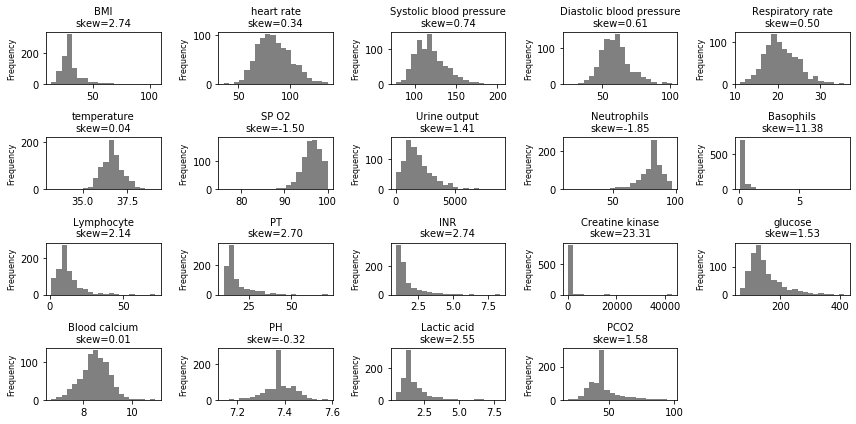

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(12, 6))
for col, ax in zip(col_w_nulls, axes.ravel()):
    train_prc[col].plot(kind='hist', bins=20, color='gray', ax=ax)
    ax.set_title(f"{col}\nskew={train_prc[col].skew():.2f}", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=8)
    
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

결측치를 모두 평균이나 중앙값으로 대체했기 때문에 그 값의 분포가 평균이나 중앙값에 몰려있는 경우가 발생했다.

# EDA

## Comorbidities

### $H_0$: 다른 병이 있는 경우 사망률이 높을 것이다.

In [13]:
comorbidities = [col for col in train_prc.columns if train_prc[col].dtype=='int64' and col not in ['age', 'gendera', 'EF']]

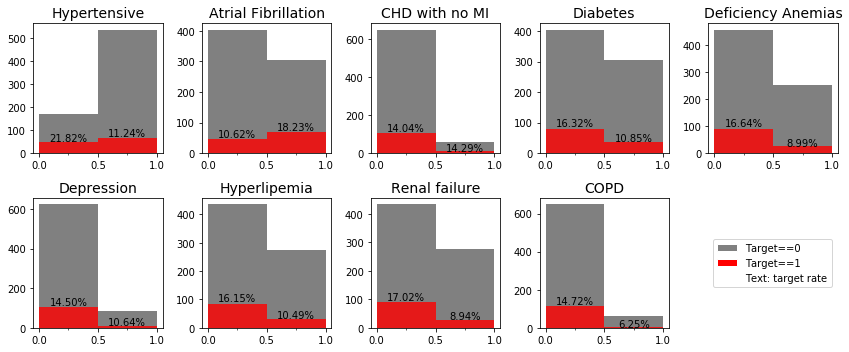

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.ravel()):
    if i==9:
        break
    temp_neg = train[train['outcome']==0][comorbidities[i]]
    temp_pos = train[train['outcome']==1][comorbidities[i]]
    
    counts_neg, bins_neg = np.histogram(temp_neg, bins=2)
    counts_pos, bins_pos = np.histogram(temp_pos, bins=2)
    
    n, bins, patches = ax.hist(temp_neg, bins=bins_neg, color='gray')
    ax.hist(temp_pos, bins=bins_pos, color='r', alpha=0.8)
    
    ticks = [patch._x0+0.25 for patch in patches]
    ticklabels = ['neg', 'pos']
    ax.set_xticks(ticks, ticklabels)

    for j in range(2):
        temp = train[train[comorbidities[i]]==j]['outcome']
        ax.text(ticks[j], temp_pos.value_counts()[j].sum()*1.1,
                f"{temp.mean()*100:.2f}%",
                ha='center')
        
    ax.set_title(comorbidities[i], fontsize=14)
    
legend_elements = [Patch(facecolor='gray', edgecolor='w',
                         label='Target==0'),
                   Patch(facecolor='r', edgecolor='w',
                         label='Target==1'),
                   Patch(facecolor='w', edgecolor='w',
                         label='Text: target rate')]
axes[-1, -1].axis('off')
axes[-1, -1].legend(handles=legend_elements, loc='center left')

plt.tight_layout()
plt.show()

다른 병을 앓고 있는 경우(neg, pos) 중환자실에서 사망(blue: alive, orange: dead) 비율(%)을 확인한 그래프다. 다른 병이 있더라도 사망 여부와는 크게 상관 없어보인다. 반대로 병이 없을 경우에 사망 비율이 더 높게 나타났다.

### T-test

In [15]:
# Only Train data
comorbidities_p = {}
print(f"{'Comorbidity':20s}| P-value")
print("=============================")
for col in comorbidities:
    t, pvalue = stats.ttest_ind(train_prc[train_prc['outcome']==0][col],
                                train_prc[train_prc['outcome']==1][col])
    comorbidities_p[col] = pvalue
    print(f"{col:20s}: {pvalue:.3f}")

Comorbidity         | P-value
Hypertensive        : 0.000
Atrial Fibrillation : 0.002
CHD with no MI      : 0.955
Diabetes            : 0.026
Deficiency Anemias  : 0.003
Depression          : 0.311
Hyperlipemia        : 0.024
Renal failure       : 0.001
COPD                : 0.061


### Dimension Reduction

In [16]:
def dimension_reduction(df, cols):
    svd = TruncatedSVD(n_components=2)
    tsne = TSNE(n_components=2)
    
    df_svd = svd.fit_transform(df[cols])
    df_tsne = tsne.fit_transform(df[cols])
    df_umap = umap.UMAP().fit_transform(df[cols])
    
    titles = ['SVD', 'TSNE', 'UMAP']
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    for i, decomp in enumerate([df_svd, df_tsne, df_umap]):
        sns.scatterplot(data=decomp, x=decomp[:, 0], y=decomp[:, 1],
                        hue=df['outcome'], palette=['gray', 'r'], alpha=0.5, ax=axes[i])
        axes[i].set_title(titles[i])

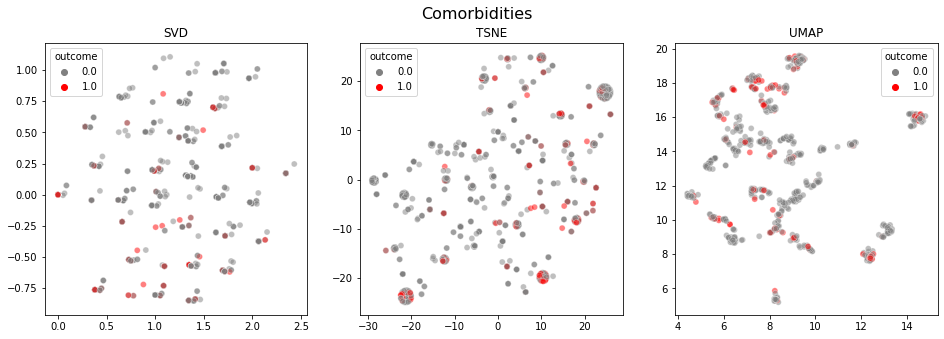

In [17]:
# All features
dimension_reduction(train_prc, comorbidities)
plt.suptitle("Comorbidities", fontsize=16)
plt.show()

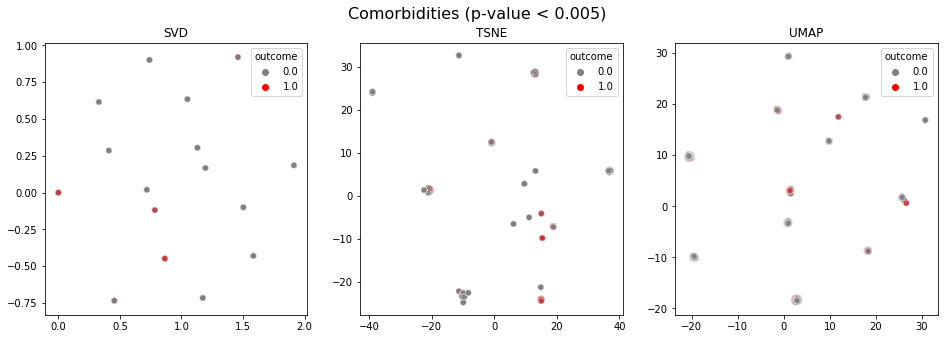

In [18]:
# Only features with pvalue < 0.005
comorbidities_low = [k for k, v in comorbidities_p.items() if v <0.005]
dimension_reduction(train_prc, comorbidities_low)
plt.suptitle("Comorbidities (p-value < 0.005)", fontsize=16)
plt.show()

## Vital Signs

### $H_0$: 사망률이 높은 경우에는 활력 징후들이 차이를 나타낼 것이다.

In [19]:
vitals = list(train_prc.columns[13:20])

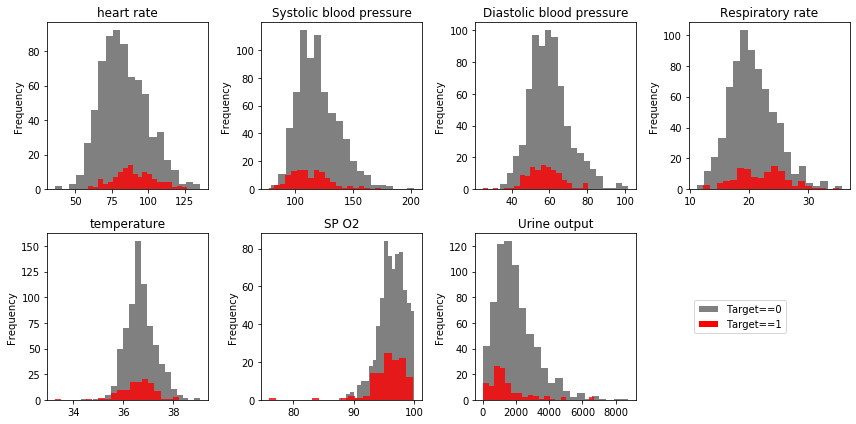

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for col, ax in zip(vitals, axes.ravel()):
    train_prc.query("outcome==0")[col].plot(kind='hist', bins=20, color='gray', ax=ax)
    train_prc.query("outcome==1")[col].plot(kind='hist', bins=20, color='r', alpha=0.8, ax=ax)
    ax.set_title(col, fontsize=12)
    
legend_elements = [Patch(facecolor='gray', edgecolor='w',
                         label='Target==0'),
                   Patch(facecolor='r', edgecolor='w',
                         label='Target==1')]
axes[-1, -1].axis('off')
axes[-1, -1].legend(handles=legend_elements, loc='center left')

plt.tight_layout()
plt.show()

### T-test

In [21]:
# Only Train data
vitals_p = {}
print(f"{'Vital Sign':25s}| P-value")
print("==================================")
for col in vitals:
    t, pvalue = stats.ttest_ind(train_prc[train_prc['outcome']==0][col],
                                train_prc[train_prc['outcome']==1][col])
    vitals_p[col] = pvalue
    print(f"{col:25s}: {pvalue:.3f}")

Vital Sign               | P-value
heart rate               : 0.000
Systolic blood pressure  : 0.000
Diastolic blood pressure : 0.005
Respiratory rate         : 0.000
temperature              : 0.016
SP O2                    : 0.013
Urine output             : 0.000


### Dimension Reduction

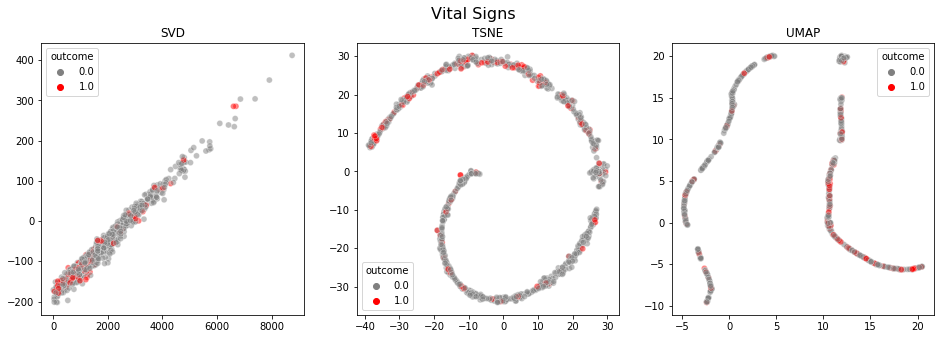

In [22]:
# All features
dimension_reduction(train_prc, vitals)
plt.suptitle("Vital Signs", fontsize=16)
plt.show()

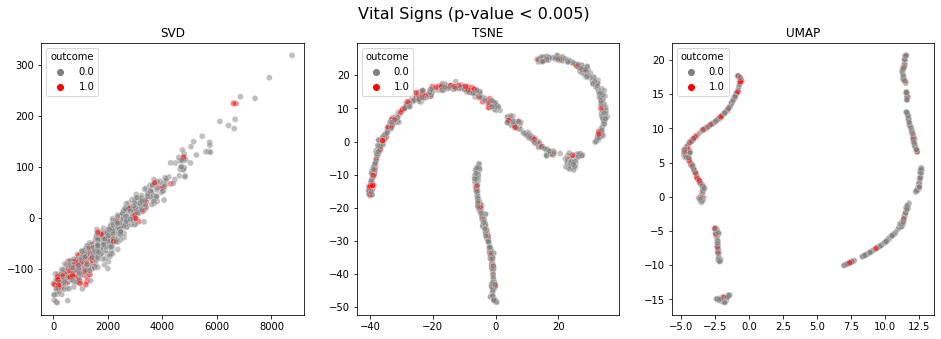

In [23]:
# Only features with pvalue < 0.005
vitals_low = [k for k, v in vitals_p.items() if v <0.005]
dimension_reduction(train_prc, vitals_low)
plt.suptitle("Vital Signs (p-value < 0.005)", fontsize=16)
plt.show()

## Laboratory Variables

### $H_0$: 사망률이 높은 경우에는 병리 수치들이 차이를 나타낼 것이다.

In [24]:
lab = list(train.columns[22:])

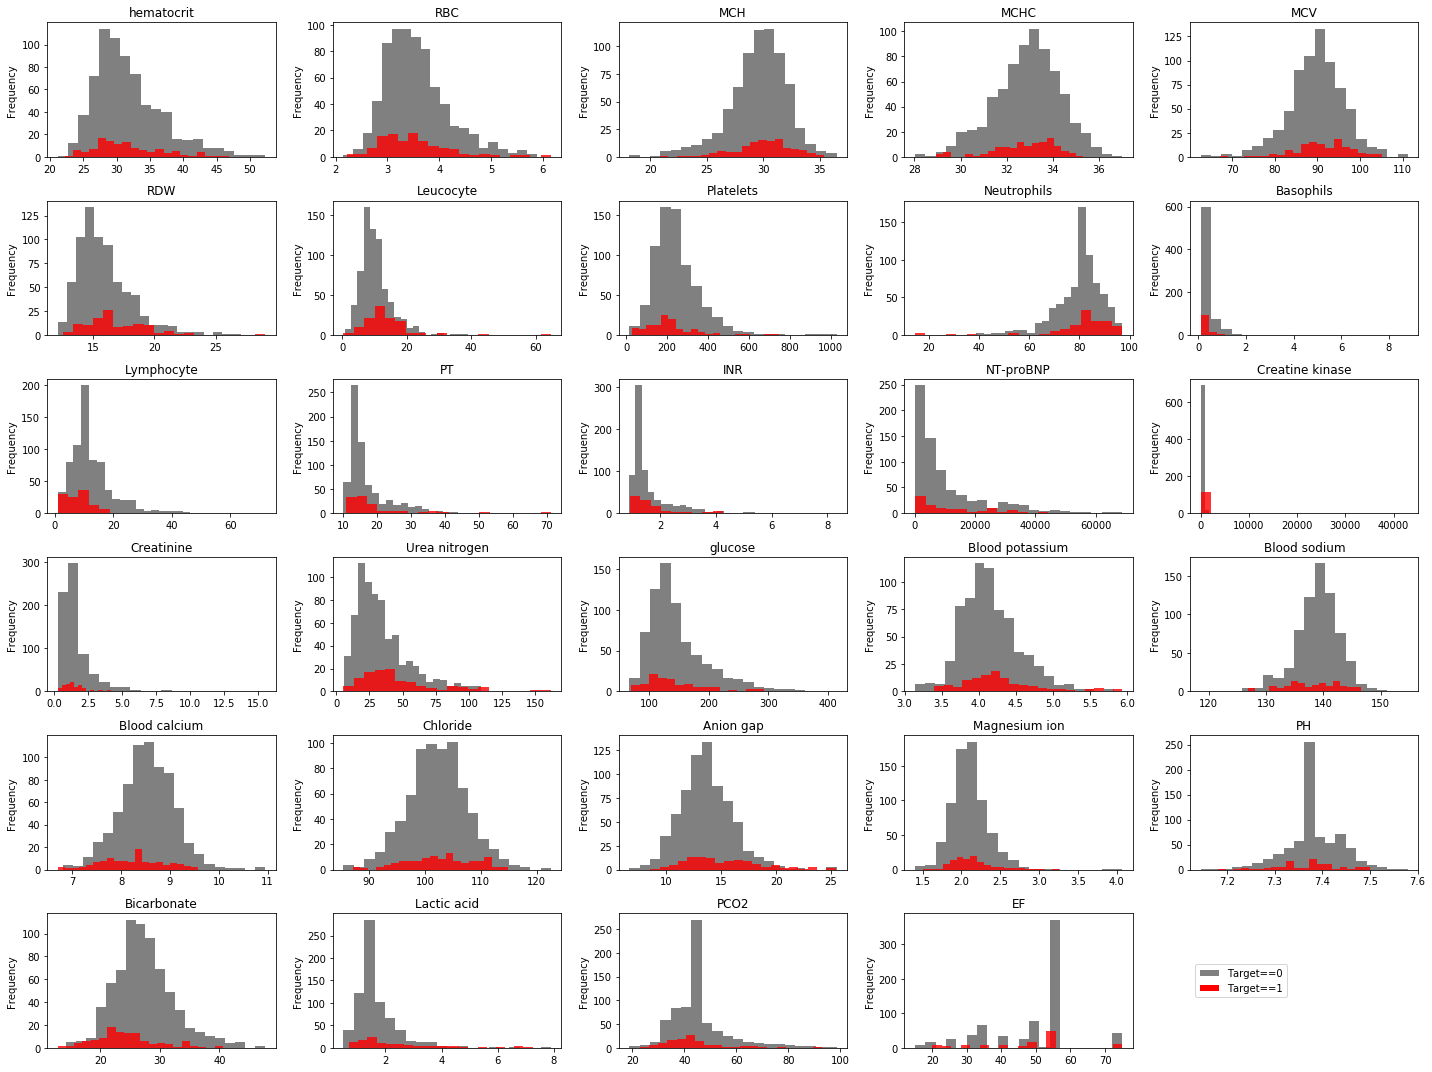

In [25]:
fig, axes = plt.subplots(6, 5, figsize=(20, 15))
for col, ax in zip(lab, axes.ravel()):
    train_prc.query("outcome==0")[col].plot(kind='hist', bins=20, color='gray', ax=ax)
    train_prc.query("outcome==1")[col].plot(kind='hist', bins=20, color='r', alpha=0.8, ax=ax)
    ax.set_title(col, fontsize=12)
    
legend_elements = [Patch(facecolor='gray', edgecolor='w',
                         label='Target==0'),
                   Patch(facecolor='r', edgecolor='w',
                         label='Target==1')]

axes[-1, -1].axis('off')
axes[-1, -1].legend(handles=legend_elements, loc='center left')

plt.tight_layout()
plt.show()

### T-test

In [26]:
# Only Train data
lab_p = {}
print("Laboratory Variable | P-value")
print("=============================")
for col in lab:
    t, pvalue = stats.ttest_ind(train_prc[train_prc['outcome']==0][col],
                                train_prc[train_prc['outcome']==1][col])
    lab_p[col] = pvalue
    print(f"{col:20s}: {pvalue:.3f}")

Laboratory Variable | P-value
hematocrit          : 0.704
RBC                 : 0.233
MCH                 : 0.098
MCHC                : 0.603
MCV                 : 0.019
RDW                 : 0.000
Leucocyte           : 0.000
Platelets           : 0.003
Neutrophils         : 0.055
Basophils           : 0.780
Lymphocyte          : 0.000
PT                  : 0.001
INR                 : 0.000
NT-proBNP           : 0.004
Creatine kinase     : 0.047
Creatinine          : 0.539
Urea nitrogen       : 0.000
glucose             : 0.773
Blood potassium     : 0.004
Blood sodium        : 0.019
Blood calcium       : 0.000
Chloride            : 0.330
Anion gap           : 0.000
Magnesium ion       : 0.162
PH                  : 0.006
Bicarbonate         : 0.000
Lactic acid         : 0.000
PCO2                : 0.090
EF                  : 0.397


### Dimension Reduction

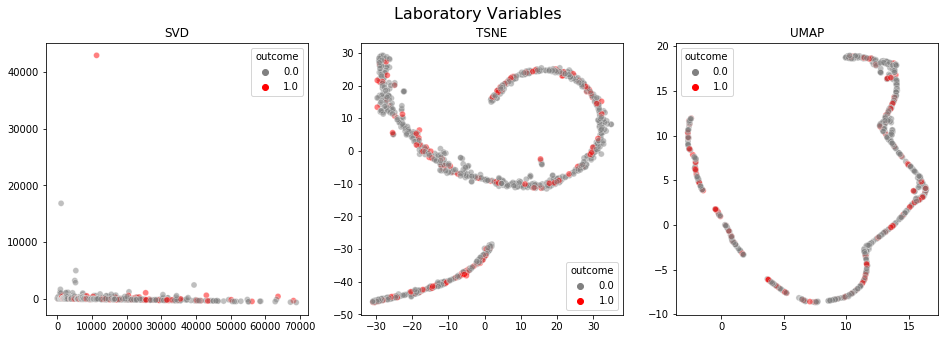

In [27]:
dimension_reduction(train_prc, lab)
plt.suptitle("Laboratory Variables", fontsize=16)
plt.show()

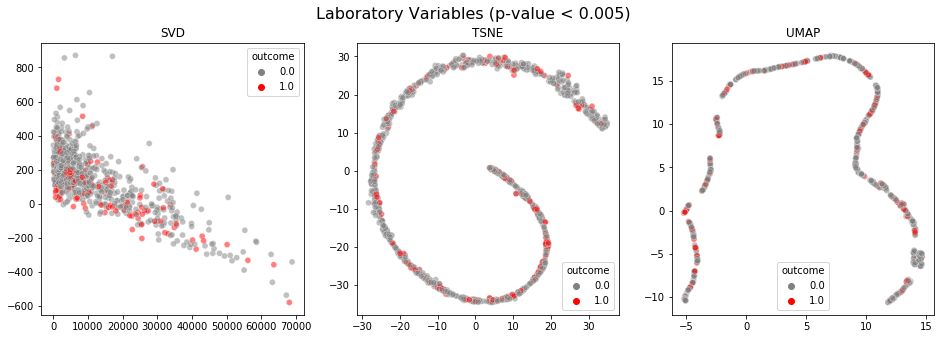

In [28]:
# Only features with pvalue < 0.005
lab_low = [k for k, v in lab_p.items() if v<0.005]
dimension_reduction(train_prc, lab_low)
plt.suptitle("Laboratory Variables (p-value < 0.005)", fontsize=16)
plt.show()

차원 축소 써봤는데 별 차이는 없어보인다. pvalue 낮은 컬럼만 따로 봤는데도 그러네
알수 없구만

# Modeling

In [29]:
# Scoring function
def scores(true, pred_prob):
    pred = np.where(pred_prob<0.5, 0, 1)
    
    auc_ = roc_auc_score(true, pred_prob)
    f1_ = f1_score(true, pred)
    # acc_ = accuracy_score(true, pred)
    # precision_ = precision_score(true, pred)
    recall_ = recall_score(true, pred)
    return pred, auc_, f1_, recall_

def print_scores(name, true, pred_prob):
    pred, auc_, f1_, recall_ = scores(true, pred_prob)
    
    print(f"Model: {name}")
    print("="*60, "\n")
    print("Confusion Matrix:")
    print(confusion_matrix(true, pred))
    print("\n", "="*60, "\n")
    print(f"AUC Score: {auc_:.5f}")
    print(f"F1 Score: {f1_:.5f}")
    # print(f"Accuracy Score: {acc_:.5f}")
    # print(f"Precision Score: {precision_:.5f}")
    print(f"Recall Score: {recall_:.5f}")
    print( "\n", "="*60, "\n")
    print(classification_report(true, pred))

## Baseline

In [30]:
y_pred_base = [train_prc['outcome'].mode().item()]*len(train_prc)
score_base = {'auc': roc_auc_score(train_prc['outcome'], y_pred_base),
              'f1': f1_score(train_prc['outcome'], y_pred_base),
              # 'acc': accuracy_score(train_prc['outcome'], y_pred_base),
              # 'precision': precision_score(train_prc['outcome'], y_pred_base),
              'recall': recall_score(train_prc['outcome'], y_pred_base)}

## Compare models
- KNeighbors Classifier
- Logistic Regression
- LightGBM Classifier

In [31]:
# target split
X = train_prc.drop('outcome', axis=1)
y = train_prc['outcome']

X_test = test_prc.drop('outcome', axis=1)
y_test = test_prc['outcome']

In [32]:
# train, valid set split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, random_state=42
)

# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [33]:
# Model define
knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression(solver='liblinear')
lgb_clf = LGBMClassifier()

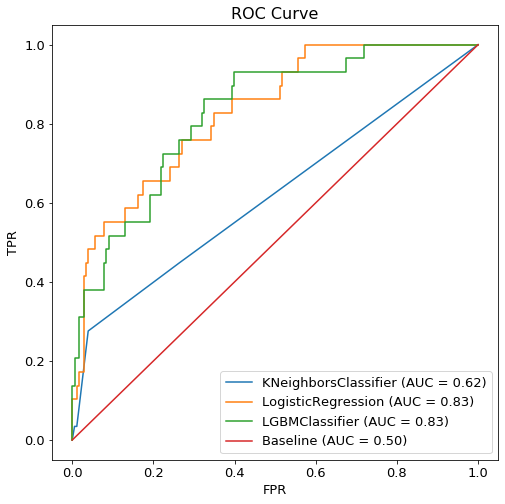

In [34]:
# ROC plot with default values
fig, ax = plt.subplots(figsize=(8, 8))
for i, clf in enumerate([knn_clf, lr_clf, lgb_clf]):
    
    if clf != lgb_clf:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict_proba(X_valid_scaled)[:, 1]
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_valid)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                              estimator_name=str(clf).split('(')[0])
    display.plot(ax=ax)
    # print(f"AUC Score: {roc_auc_score(y_valid, y_pred):.5f}")
    
plt.plot([0, 1], [0, 1], label='Baseline (AUC = 0.50)')
plt.title("ROC Curve", fontsize=16)
plt.legend(fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("FPR", fontsize=13)
plt.ylabel("TPR", fontsize=13)
plt.show()

## Hyperparameter Tuning

### KNeighbors Classifier

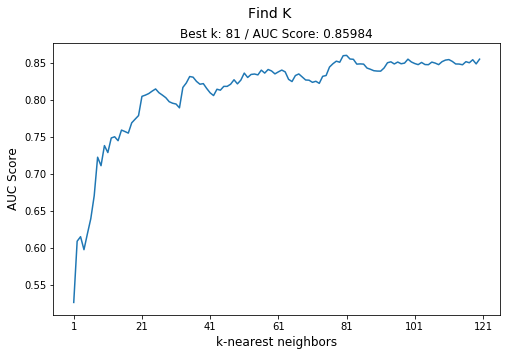

In [35]:
scores_roc = []
scores_f1 = []
scores_recall = []
for i in range(1, 121):
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(X_train_scaled, y_train)
    
    y_pred_prob = knn_clf.predict_proba(X_valid_scaled)[:, 1]
    y_pred = knn_clf.predict(X_valid_scaled)
    
    scores_roc.append(roc_auc_score(y_valid, y_pred_prob))
    scores_f1.append(f1_score(y_valid, y_pred))
    scores_recall.append(recall_score(y_valid, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 121), scores_roc)
plt.xticks(range(1, 122, 20))
plt.xlabel("k-nearest neighbors", fontsize=12)
plt.ylabel("AUC Score", fontsize=12)
plt.suptitle("Find K", fontsize=14)
plt.title(f"Best k: {scores_roc.index(max(scores_roc))+1} / AUC Score: {max(scores_roc):.5f}")
plt.show()

In [36]:
knn_clf = KNeighborsClassifier(n_neighbors=81)
knn_clf.fit(X_train_scaled, y_train)
y_pred = knn_clf.predict(X_valid_scaled)
confusion_matrix(y_valid, y_pred)

array([[178,   0],
       [ 29,   0]], dtype=int64)

AUC 점수가 높지만 실제로는 모두 음성으로 예측해 높아진 점수이다. 사망자를 예측하는 모델이기 때문에 AUC 점수가 가장 높은 k를 선택하는 것은 적절하지 않아보인다.

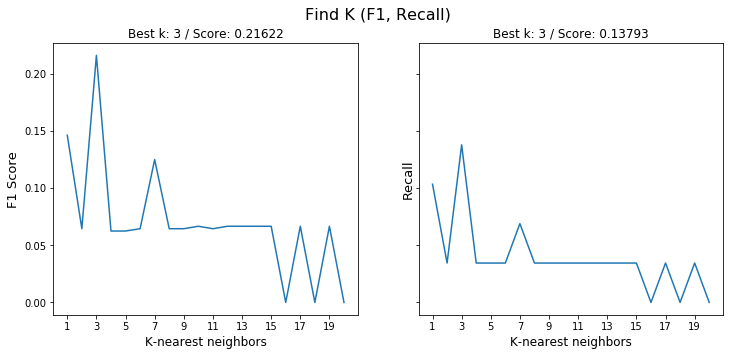

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, score in zip(axes, [scores_f1, scores_recall]):
    ax.plot(range(1, 21), score[:20])
    ax.set_xlabel("K-nearest neighbors", fontsize=12)
    ax.set_xticks(range(1, 21, 2))
    ax.set_title(f"Best k: {score.index(max(score))+1} / Score: {max(score):.5f}")
plt.suptitle("Find K (F1, Recall)", fontsize=16)
axes[0].set_ylabel("F1 Score", fontsize=13)
axes[1].set_ylabel("Recall", fontsize=13)
plt.show()

In [38]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_scaled, y_train)
y_pred_prob_knn = knn_clf.predict_proba(X_valid_scaled)[:, 1]

print_scores('KNN', y_valid, y_pred_prob_knn)

Model: KNN

Confusion Matrix:
[[174   4]
 [ 25   4]]


AUC Score: 0.61517
F1 Score: 0.21622
Recall Score: 0.13793


              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       178
         1.0       0.50      0.14      0.22        29

    accuracy                           0.86       207
   macro avg       0.69      0.56      0.57       207
weighted avg       0.82      0.86      0.82       207



F1과 Recall 점수를 기반으로 했을 때 가장 높은 k는 3이다. 

### Logistic Regression

In [39]:
params = {'C': np.logspace(-4, 4, 9),
          'max_iter': range(100, 2000, 100)}

lr_clf = LogisticRegression(solver='liblinear',
                            class_weight='balanced')

fold = StratifiedKFold(n_splits=3)
lr_random = RandomizedSearchCV(lr_clf, param_distributions=params,
                               cv=fold, n_iter=100, 
                               scoring=['roc_auc', 'f1', 'recall'],
                               refit='f1')
lr_random.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(class_weight='balanced',
                                                solver='liblinear'),
                   n_iter=100,
                   param_distributions={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                                        'max_iter': range(100, 2000, 100)},
                   refit='f1', scoring=['roc_auc', 'f1', 'recall'])

In [40]:
y_pred_prob_lr = lr_random.predict_proba(X_valid_scaled)[:, 1]
print_scores('Logistic Regressor', y_valid, y_pred_prob_lr)

Model: Logistic Regressor

Confusion Matrix:
[[135  43]
 [ 11  18]]


AUC Score: 0.77547
F1 Score: 0.40000
Recall Score: 0.62069


              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83       178
         1.0       0.30      0.62      0.40        29

    accuracy                           0.74       207
   macro avg       0.61      0.69      0.62       207
weighted avg       0.84      0.74      0.77       207



### LightGBM Classifier

In [41]:
params = {'n_estimators': range(500, 1500, 50),
          'learning_rate': np.arange(0.03, 0.1, 0.01),
          'colsample_bytree': np.arange(0.5, 1, 0.05),
          'scale_pos_weight': np.arange(4, 6, 0.02),
          'reg_lambda': np.linspace(0, 10, 20),
          'reg_alpha': np.linspace(0, 1, 10)}

lgb_clf = LGBMClassifier(
    boosting_type='gbdt',
)

fold = StratifiedKFold(n_splits=3)
lgb_random = RandomizedSearchCV(lgb_clf, param_distributions=params,
                                n_iter=50, cv=fold, random_state=42,
                                scoring=['roc_auc', 'f1', 'recall'],
                                refit='f1')
lgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'colsample_bytree': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'learning_rate': array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'n_estimators': range(500, 1500, 50),
                                        'reg_alpha': array([0.        , 0.11111111, 0.2222...
       4.66, 4.68, 4.7 , 4.72, 4.74, 4.76, 4.78, 4.8 , 4.82, 4.84, 4.86,
       4.88, 4.9 , 4.92, 4.94, 4.96, 4.98, 5.  , 5.02, 5.04, 5.06, 5.08,
       5.1 , 5.12, 5.14, 5.16, 5.18, 5.2 , 5.22, 5.24, 5.26, 5.28, 5.3 ,
       5.32, 5.34, 5.36, 5.38, 5.4 , 5.42, 5.44, 5.46, 5.48, 5.5 , 5.52,
       5.54, 5.56, 5.58, 5.6 , 5.62, 5.64, 5.66, 5.68, 5.7 , 5.72, 5.74,
       5.76, 5.78, 5.8 , 5.82, 5.84, 5.86, 5.88, 5.9 , 5.92, 5.94, 5.96,
    

In [42]:
y_pred_prob_lgb = lgb_random.predict_proba(X_valid)[:, 1]
print_scores('Lightgbm Classifier', y_valid, y_pred_prob_lgb)

Model: Lightgbm Classifier

Confusion Matrix:
[[167  11]
 [ 16  13]]


AUC Score: 0.82100
F1 Score: 0.49057
Recall Score: 0.44828


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       178
         1.0       0.54      0.45      0.49        29

    accuracy                           0.87       207
   macro avg       0.73      0.69      0.71       207
weighted avg       0.86      0.87      0.86       207



In [43]:
y_pred_prob_blend = (y_pred_prob_lgb +  y_pred_prob_lr)/2

model_scores = {'Baseline(mode)': score_base.values(),
                'KNN Classifier': scores(y_valid, y_pred_prob_knn)[1:],
                'Logistic Regression': scores(y_valid, y_pred_prob_lr)[1:],
                'LGBM Classifier': scores(y_valid, y_pred_prob_lgb)[1:],
                'Blending Logistic and LGBM': scores(y_valid, y_pred_prob_blend)[1:]}

In [44]:
pd.DataFrame(model_scores, index=['AUC', 'F1', 'Recall'])

,Baseline(mode),KNN Classifier,Logistic Regression,LGBM Classifier,Blending Logistic and LGBM
AUC,0.5,0.615169,0.775475,0.821000,0.809764
F1,0.0,0.216216,0.400000,0.490566,0.561404
Recall,0.0,0.137931,0.620690,0.448276,0.551724


목표는 환자들의 사망 여부를 예측해 생존할 수 있도록 하는 것이기 때문에 AUC, F1, Recall 세 점수를 확인 했다.  
기준모델은 모든 예측이 최빈값을 나타내었을 때이다. 최빈값이 0(생존)이므로 재현율(Recall)은 0이 되고 F1도 0이 된다.

KNN, 로지스틱 회귀, LGBM 분류기 세 모델로 테스트 데이터를 예측 했을 때 모두 기준모델보다 높은 점수를 나타냈다. KNN 분류기는 기준 모델보다는 높지만 다른 두 분류기보다 점수가 낮았다. 로지스틱 회귀는 AUC와 재현율에서 가장 높은 점수를 얻었다. LGBM 분류기는 가장 높은 F1 점수를 얻었다.

사망자를 생존자로 잘못 분류하지 않는 것도 중요하지만 생존자를 사망자로 예측하지 않는것도 중요하기에 세 지표를 모두 고려했다.  
로지스틱 회귀 모델과 LGBM 분류기를 블랜딩했을 경우에는 F1점수는 증가했고 AUC와 Recall은 평균에 가깝게 나타났다.  
테스트에 이 모델을 사용한다.

# Model Interpret

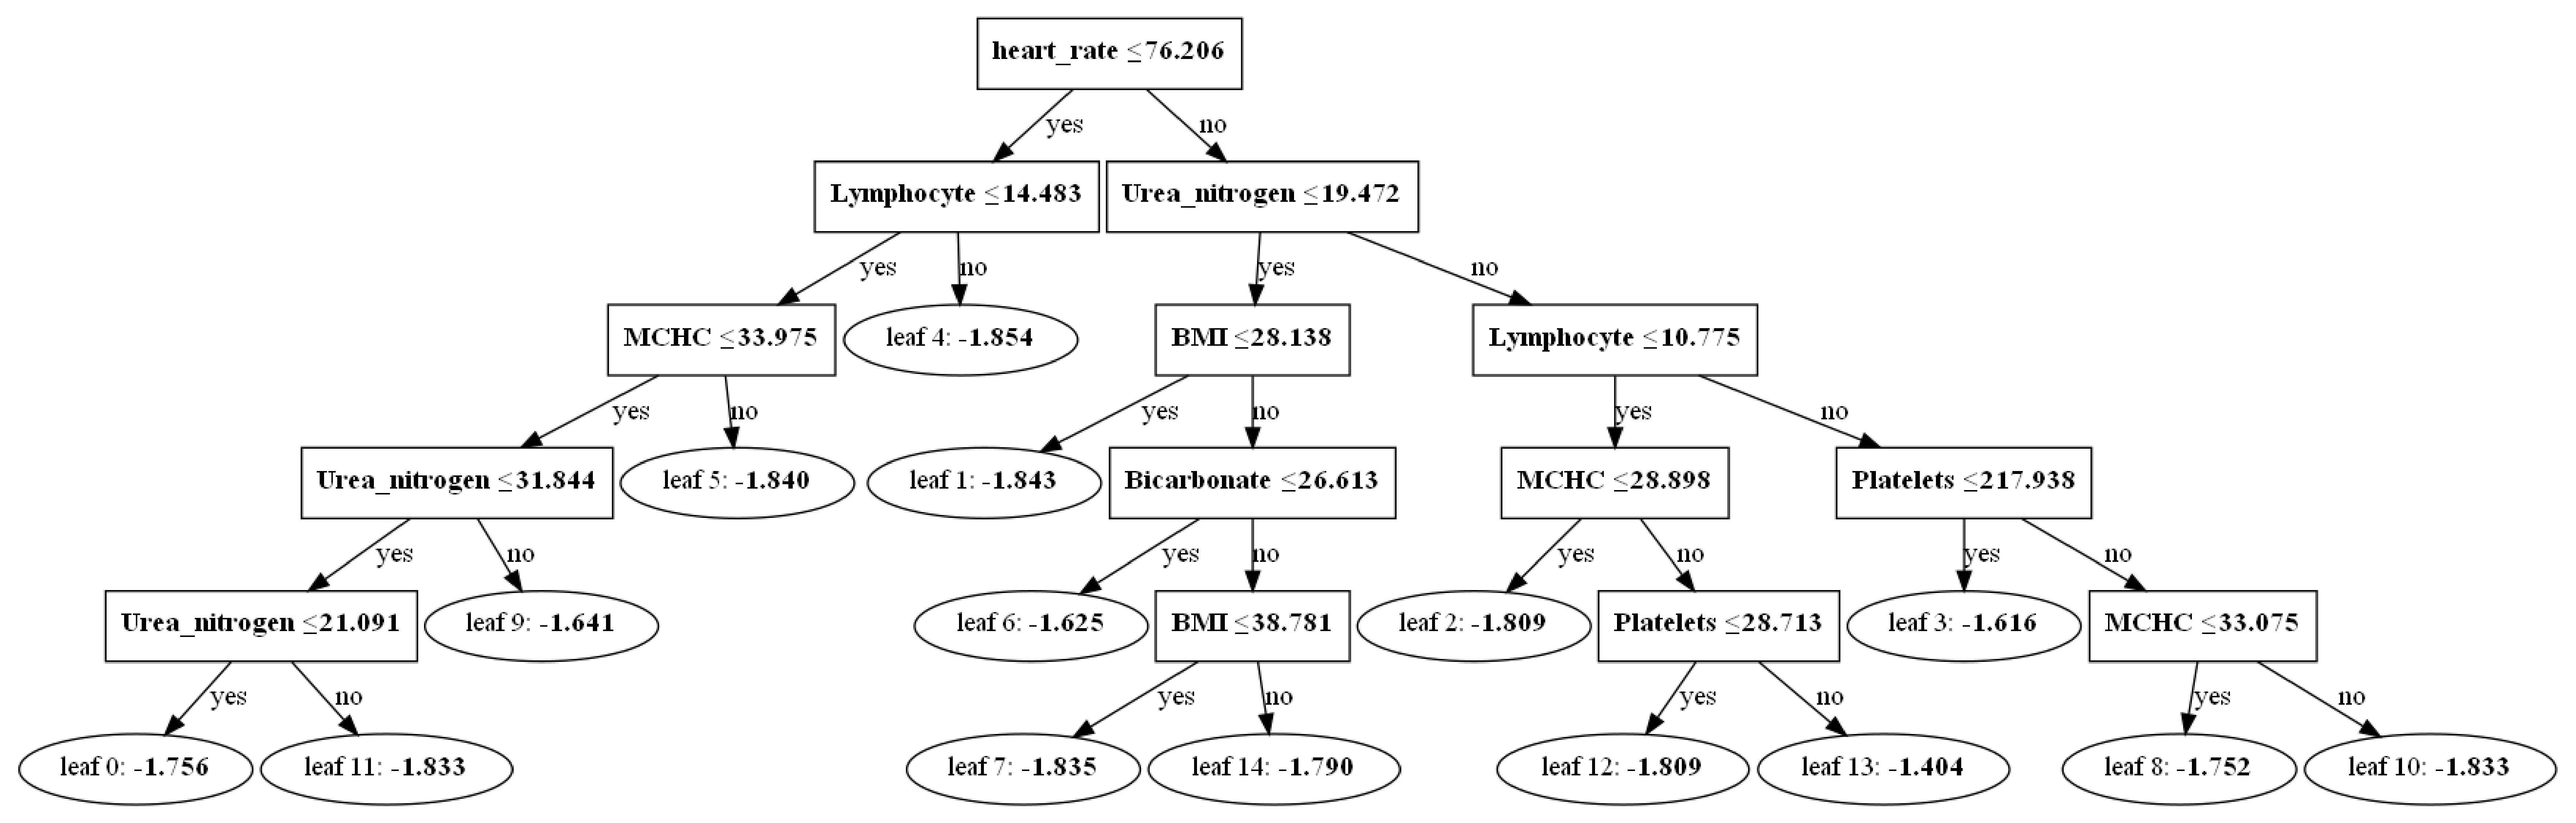

In [45]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
                         **lgb_random.best_params_)
lgb_clf.fit(X_train, y_train)

lgbm.plot_tree(lgb_clf, figsize=(30, 20), orientation='vertical', dpi=300)
plt.show()

## Feature Importance

## PDP

- 어떤 특성이 중요한가? 
- pvalue가 낮은 특성과 일치하는가? 
- 그 특성들만 사용했을 때 모델 점수가 어떻게 변하는가?

# Predict
- 위에서 정한걸로 최종 모델 예측
- 가설에 대한 결론과 Question 답 도출

In [46]:
knn_clf_fin = KNeighborsClassifier(n_neighbors=3)
lr_clf_fin = LogisticRegression(solver='liblinear',
                                class_weight='balanced',
                                **lr_random.best_params_)
lgb_clf_fin = LGBMClassifier(boosting_type='gbdt',
                             **lgb_random.best_params_)

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

knn_clf_fin.fit(X_scaled, y)
lr_clf_fin.fit(X_scaled, y)
lgb_clf_fin.fit(X, y)

y_pred_prob_knn_fin = knn_clf_fin.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_lr_fin = lr_clf_fin.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_lgb_fin = lgb_clf_fin.predict_proba(X_test)[:, 1]
y_pred_prob_blend_fin = (y_pred_prob_lr_fin +  y_pred_prob_lgb_fin)/2

In [48]:
model_scores = {'Baseline(mode)': score_base.values(),
                'KNN Classifier': scores(y_test, y_pred_prob_knn_fin)[1:],
                'Logistic Regression': scores(y_test, y_pred_prob_lr_fin)[1:],
                'LGBM Classifier': scores(y_test, y_pred_prob_lgb_fin)[1:],
                'Blending Logistic and LGBM': scores(y_test, y_pred_prob_blend_fin)[1:]}

In [49]:
pd.DataFrame(model_scores, index=['AUC', 'F1', 'Recall'])

,Baseline(mode),KNN Classifier,Logistic Regression,LGBM Classifier,Blending Logistic and LGBM
AUC,0.5,0.687368,0.769858,0.812745,0.797569
F1,0.0,0.214286,0.405797,0.450704,0.481928
Recall,0.0,0.139535,0.651163,0.372093,0.465116
